In [87]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rcParams = {'font.size': 20 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)


In [88]:
counts_dict = eval(open('/Users/harihara/Research-Activities/Data/SCRAPT/Lupus-Microbiome-Published/Counts.dict',
                        'r').read())

In [59]:
def Parse_DNACLUST(filepath, cluster):
    op = {}
    counts = []
    centroids = []
    lines = open(filepath,'r').readlines()
    for l in lines:
        seqs = l.rstrip().split()
        for s in seqs:
            op[s] = cluster
            centroids.append(seqs[0])
            try:
                counts.append(int(counts_dict[s]['Counts']))
            except KeyError:
                counts.append(1)
        cluster += 1
    df_scrapt_clusters = pd.DataFrame(data = {'Sequence_ID':list(op.keys()), 
                                              'Cluster_ID':list(op.values()),
                                              'Centroid':centroids,
                                              'SCRAPT_Counts':counts})
    return df_scrapt_clusters, cluster

def Load_SCRAPT_Results(data_path):
    cluster = 0
    df_scrapt = pd.DataFrame()
    for s in listdir(data_path):
        if s.startswith('Iteration'):
            print(s)
            filepath = data_path+s+'/dnaclust_mode_bait'
            df_scrapt_iter, cluster = Parse_DNACLUST(filepath, cluster)
            df_scrapt = df_scrapt.append(df_scrapt_iter, ignore_index = True)
    print(len(df_scrapt))
    df_scrapt = df_scrapt.groupby('Centroid').aggregate({'Cluster_ID':'count','SCRAPT_Counts':sum})
    return df_scrapt

def Load_DADA2_Results(seq_path, results_path):
    buf = open(seq_path, 'r').readlines()
    op = []
    for i in range(0, len(buf), 2):
        seq_id = buf[i].replace("\n","").replace(">","")
        seq = buf[i+1].replace("\n","")
        op.append({'Centroid_id':seq_id, 'Seq':seq})
    df_centroids = pd.DataFrame(op)
    df_centroids = df_centroids.set_index('Seq')
    df_cluster_counts = pd.read_csv(results_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                    index_col = 'Seq')
    
    df_cluster_counts = df_cluster_counts.join(df_centroids)
    return df_cluster_counts.set_index('Centroid_id')[['DADA2_Counts']]


In [141]:
df_SCRAPT = Load_SCRAPT_Results('/Users/harihara/Mount/Iterative_Clustering/Experiments/\
Lupus-Microbiome-Published/Adaptive_With_Modeshifting/sim_0.98/alpha_0.1/')
df_SCRAPT = df_SCRAPT.reset_index().rename(columns = {'Centroid':'SCRAPT_Centroid'})

Iteration_27
Iteration_1
Iteration_7
Iteration_32
Iteration_31
Iteration_14
Iteration_21
Iteration_23
Iteration_39
Iteration_13
Iteration_41
Iteration_15
Iteration_2
Iteration_12
Iteration_44
Iteration_22
Iteration_4
Iteration_19
Iteration_29
Iteration_42
Iteration_35
Iteration_8
Iteration_6
Iteration_43
Iteration_36
Iteration_17
Iteration_40
Iteration_48
Iteration_47
Iteration_24
Iteration_9
Iteration_20
Iteration_49
Iteration_33
Iteration_10
Iteration_37
Iteration_34
Iteration_25
Iteration_11
Iteration_30
Iteration_45
Iteration_46
Iteration_28
Iteration_0
Iteration_3
Iteration_16
Iteration_18
Iteration_5
Iteration_38
Iteration_26
901942


In [151]:
df_DADA2 = Load_DADA2_Results('/Users/harihara/Downloads/dada2_output.fna', 
                              '/Users/harihara/Downloads/results_luo.csv')
df_DADA2 = df_DADA2.reset_index().rename(columns = {'Centroid_id':'DADA2_Centroid'})
df_DADA2 = df_DADA2.set_index('DADA2_Centroid')

In [158]:
lines = open('/Users/harihara/Mount/Iterative_Clustering/Experiments/Lupus-Microbiome-Published/\
DADA2_Benchmarks/results_dada2_scrapt/scrapt_98_radius_99').readlines()
op = []
for l in lines:
    seqs = l.rstrip().split()
    d = {}
    centroid = seqs[0]
    for s in seqs[1:]:
        op.append({'DADA2_Centroid':centroid, 'SCRAPT_Centroid':s})
df_map = pd.DataFrame(op)

In [159]:
df_SCRAPT_MAP = pd.merge(df_SCRAPT, df_map, on = 'SCRAPT_Centroid', how = 'left')
#print(df_SCRAPT_MAP.groupby(['DADA2_Centroid']).count().max())
df_SCRAPT_MAP = df_SCRAPT_MAP.groupby('DADA2_Centroid').max()[['SCRAPT_Counts']]

SCRAPT_Centroid    2
Cluster_ID         2
SCRAPT_Counts      2
dtype: int64


In [160]:
df_temp = df_SCRAPT_MAP.join(df_DADA2, how = 'outer')

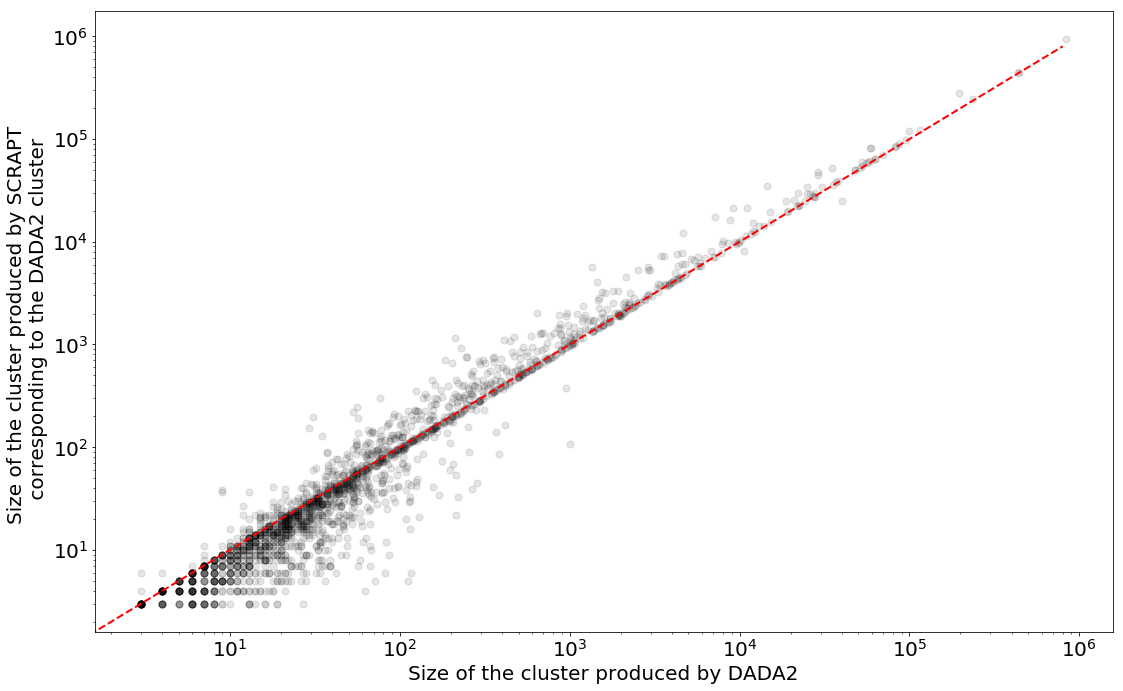

In [171]:
fig, ax = plt.subplots(1,1,figsize = (16,10))
df_temp.plot.scatter('DADA2_Counts','SCRAPT_Counts', s = 50, ax = ax, color = 'black', alpha = 0.1)
ax.plot([0,800000], [0,800000], color = 'red', linestyle = '--', linewidth = 2.0)
ax.set_xlabel('Size of the cluster produced by DADA2')
ax.set_ylabel('Size of the cluster produced by SCRAPT \n corresponding to the DADA2 cluster')

ax.set_xscale('log')
ax.set_yscale('log')
fig.tight_layout()
fig.savefig('/Users/harihara/Research-Activities/Plots/Iterative_Clustering/ISMB_Figures/Comparing_DADA2_SCRAPT_0.98.pdf')
